In [54]:
import pymc as pm
import numpy as np
from scipy import stats

import aesara.tensor as at

import os
from utility import *
from utility_data_deal import *

In [132]:
data_index_factor,data_index,data_factor= import_index_factor()
data_factor_adj,data_index_factor_adj=orthogonalized_factors(data_index_factor,data_index.name,data_factor.columns.to_list())
[IR_mean,IR_sample_mean,IR_sample_std]=Bootstrap_mean_std_IR(data_index_factor_adj)
data_index_factor_adj.index=data_index_factor_adj.index.to_period("M")

#########市场指数

dic_Style_fund,dic_fund_Style=fund_file2dic()
data_alpha=query_alpha_fund_type_data("大盘价值")
data_alpha.index= data_alpha.index.to_period("M")

######宏观指数
from load_macro import DB_new_interpolate
data = pd.DataFrame(DB_new_interpolate).ffill().iloc[:,[1,2,3]].dropna()
data.index=data.index.to_period("M")





#########


df_data = pd.DataFrame(columns = ["Period"]).set_index("Period")
date =pd.date_range(start="2010-02-01",end="2022-06-01",freq="M").to_period("M")
df_data.index=date
df_data["Test_"] = "True"
df_macro_filter = pd.concat([df_data,data],axis=1).query('Test_=="True"')

df_Factor_filter=pd.concat([df_data,data_index_factor_adj],axis=1).query('Test_=="True"')
data_alpha_filter =pd.concat([df_data,data_alpha],axis=1).query('Test_=="True"')
data_total =pd.concat([df_Factor_filter.drop("Test_",axis=1),data_alpha_filter.drop("Test_",axis=1)],axis=1).T



########DF_data
Df_alpha=data_alpha_filter.drop("Test_",axis=1).T
Df_macro = df_macro_filter.drop("Test_",axis=1).T
Df_Factor=df_Factor_filter.drop("Test_",axis=1).T

prior_mu = np.array([x for x in IR_mean])
prior_std = np.array([x for x in IR_sample_std])


In [133]:
alpha_mean__prior =2
alpha_std__prior =0.17
LKJ_eta__prior =3
LKJ_st__prior =1.0

T_len=148

__Df_alpha_model=Df_alpha.iloc[:10,:]
alpha_len = __Df_alpha_model.shape[0]
coords = {"Fund": Df_Factor.index.values, "date":data_total.columns.to_timestamp().date,"macro":Df_macro.index.values,"Alpha":__Df_alpha_model.index.values}


In [139]:

with pm.Model(coords=coords) as model_total:
   #   sharpe_ratio= pm.Normal("μ", prior_mu.T, prior_std)
#     sharpe_ratio=at.reshape(sharpe_ratio,(6,1))
#     beta = pm.Normal("beta", mu=0, sigma=20,shape=(6,3))
     
#     data_macro = pm.Data("data", Df_macro.values.astype(float),mutable=True)


#     sharpe_ratio_t = pm.Deterministic("SR_t",at.tile(sharpe_ratio,(1,148)) + at.dot(beta,data_macro))


#     sd_dist=pm.Exponential("std",1.0,shape=1)
#     #sd_dist=at.reshape(sd_dist,(6,1))
#    # sd_T =at.tile(sd_dist,(1,148)) 

#     obs = pm.Normal("obs",mu=sharpe_ratio_t*sd_dist,sigma=sd_dist,observed=Df_Factor.values)
    
    sharpe_ratio= pm.Normal("μ", prior_mu.T, prior_std, dims=("Fund"))
    sharpe_ratio=at.reshape(sharpe_ratio,(6,1))
    beta = pm.Normal("beta", mu=0, sigma=20,shape=(6,3),dims=("Fund","macro"))
    data_macro = pm.Data("data", Df_macro.values.astype(float),mutable=True,dims=("macro","date"))
    sharpe_ratio_t = pm.Deterministic("SR_t",at.tile(sharpe_ratio,(1,148)) + at.dot(beta,data_macro),dims=("Fund","date"))
    #sd_dist=pm.Exponential("std",1.0,shape=6,dims=("Fund"))
    sd_dist=pm.Exponential("std",1.0,shape=6,dims=("Fund"))
    sd_dist= at.reshape(sd_dist,(6,1))
    sd_T =at.tile(sd_dist,(1,148)) 
    obs = pm.Normal("obs",mu=sharpe_ratio_t*sd_dist,sigma=sd_dist,observed=Df_Factor,dims=("Fund", "date"))

    ############################################
    ############################################
    ###############################################
    ############################################
    factor_loading = pm.Normal("factor_loading", mu=0, sigma=20,shape=6,dims=("Fund"))
    factor_loading= at.reshape(factor_loading,(6,1))
   
    
    factor_loading_T =at.tile(factor_loading,(1,T_len))                         
    factor_loading_T=factor_loading_T*sharpe_ratio_t                
    factor_loading_sum= factor_loading_T.sum(axis=0)
    factor_loading_sum =at.reshape(factor_loading_sum,(1,T_len)) 
    factor_loading_sum_stack=at.tile(factor_loading_sum,(alpha_len,1))  
    
    alpha = pm.Normal("μ_alpha",alpha_mean__prior, alpha_std__prior)
    alpha_n = pm.Normal("IC_alpha",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))
    alpha_n= at.reshape(alpha_n,(alpha_len,1))
   
    
    IC_alpha_t = pm.Deterministic("SR_alpha_t",at.tile(alpha_n,(1,148)) + factor_loading_sum_stack,dims=("Alpha","date"))
    
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.Exponential.dist(LKJ_st__prior), compute_corr=True
    )
    
    
    
    
    
    #cov = pm.Deterministic("cov", chol.dot(chol.T))     
    __stds =  at.reshape(stds,(alpha_len,1)) 
    __stds_t = at.tile(__stds,(1,T_len)) 
    
    T_n_cov =np.eye(T_len)
    
    obs_sharpe=pm.MatrixNormal('vals', mu=IC_alpha_t*__stds_t, rowchol=chol,colcov=T_n_cov)
    
    __Df_alpha_fit_data_model=__Df_alpha_model.values[~np.isnan(__Df_alpha_model.values)]
    alpha_fit_variable = obs_sharpe[~np.isnan(__Df_alpha_model.values)]
    obss=pm.Normal("_IC",alpha_fit_variable,sigma=0.00001,observed=__Df_alpha_fit_data_model)
  
    
    

       

In [129]:
__Df_alpha_fit_data_model.shape

(394,)

In [140]:
RANDOM_SEED = 8924
with model_total:
    trace_alpha_total = pm.sample(draws=500,random_seed=RANDOM_SEED, init="advi",chains=1,n_init=500, tune=500,target_accept=0.8,return_inferencedata=True)
  
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.1635e+13
Sequential sampling (1 chains in 1 job)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1816 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [78]:
#obss.eval().shape()

In [143]:
model_total

             μ ~ N(<constant>, <constant>)
          beta ~ N(0, 20)
           std ~ Exp(f())
factor_loading ~ N(0, 20)
       μ_alpha ~ N(2, 0.17)
      IC_alpha ~ N(μ_alpha, 1)
          chol ~ _lkjcholeskycov(10, 3, <unnamed>)
          vals ~ MatrixNormal(f(chol, IC_alpha, beta, factor_loading, μ), f(chol), f())
          SR_t ~ Deterministic(f(beta, μ))
    SR_alpha_t ~ Deterministic(f(IC_alpha, beta, factor_loading, μ))
     chol_corr ~ Deterministic(f(chol))
     chol_stds ~ Deterministic(f(chol))
           obs ~ N(f(std, beta, μ), f(std))
           _IC ~ N(f(vals), 1e-05)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

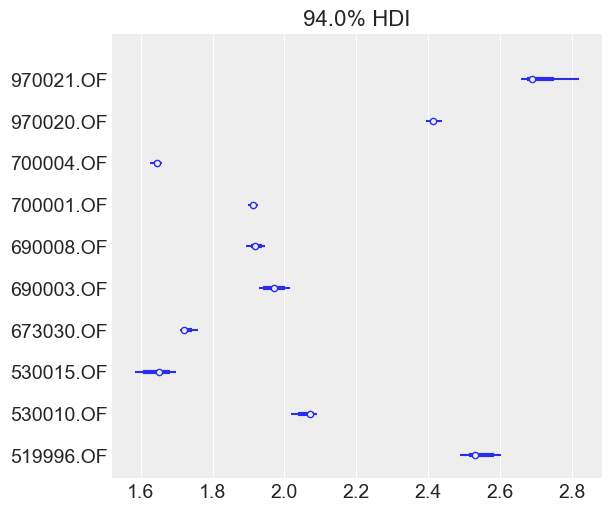

In [142]:
 az.plot_forest(
    trace_alpha_total,
    var_names=["IC_alpha"],
    combined=True,
    coords={"Alpha":__Df_alpha_model.index.values},
    labeller=az.labels.NoVarLabeller(),
)

In [145]:
trace_alpha_total_table = az.summary(trace_alpha_total, round_to=2)
trace_alpha_total_table.to_excel("macro_factor_alpha_total.xlsx")

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [146]:
trace_alpha_total_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[MSCI中国A股在岸大盘(人民币)],-0.14,0.02,-0.17,-0.11,0.01,0.01,1.57,12.60,NaN
μ[MSCI中国A股在岸低波(人民币)],-0.29,0.01,-0.32,-0.28,0.01,0.01,2.93,13.46,NaN
μ[MSCI中国A股在岸动能(人民币)],0.38,0.01,0.36,0.40,0.01,0.01,1.64,10.87,NaN
μ[MSCI中国A股在岸价值(人民币)],0.10,0.01,0.09,0.12,0.00,0.00,4.97,13.72,NaN
μ[MSCI中国A股在岸中小盘(人民币)],-0.34,0.01,-0.36,-0.33,0.01,0.01,1.44,29.94,NaN
...,...,...,...,...,...,...,...,...,...
chol_stds[5],1.76,0.03,1.71,1.80,0.03,0.03,1.33,15.02,NaN
chol_stds[6],2.08,0.02,2.05,2.12,0.02,0.02,1.36,12.52,NaN
chol_stds[7],1.54,0.02,1.51,1.56,0.01,0.01,2.09,27.53,NaN
chol_stds[8],2.97,0.02,2.94,3.00,0.01,0.00,8.98,11.02,NaN


In [147]:
pm.model_to_graphviz(model_total)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

<AxesSubplot: >

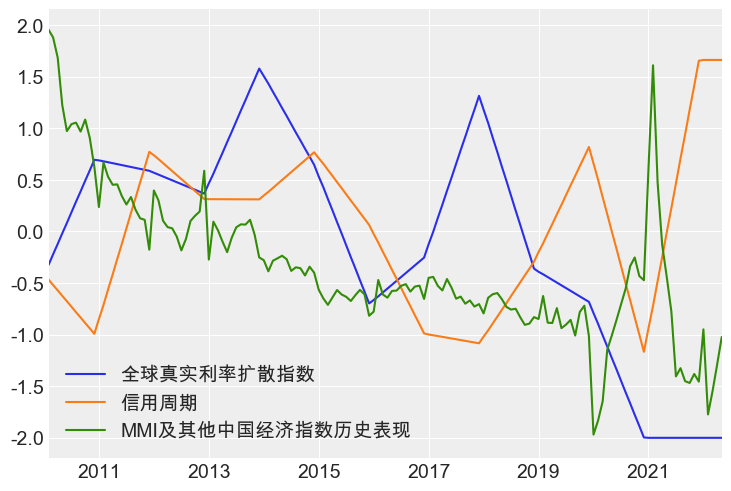

In [149]:
df_macro_filter.plot()

In [151]:
Df_Factor.shape

(6, 148)